In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

📊 Loading training data...
🛠 Applying Feature Engineering...
Selected Features (15): ['S2', 'E2', 'E3', 'P8', 'P9', 'P10', 'P12', 'P13', 'S1', 'S5', 'I2', 'U1', 'U2', 'VOL_20', 'MOM_5']

🤖 Training LightGBM Model...
✓ Model trained successfully.


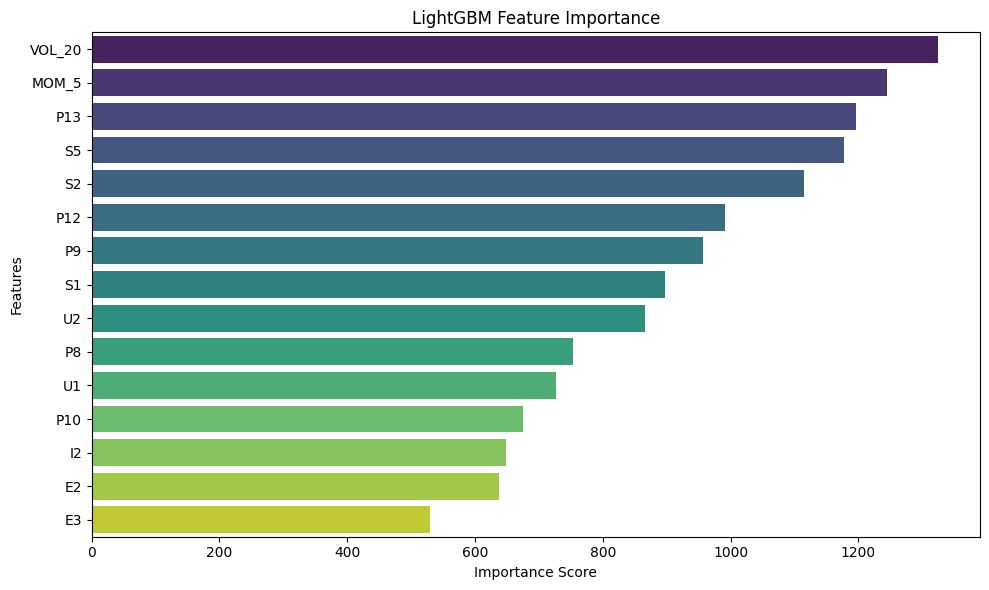


🔄 Starting Time-Series Cross-Validation & Simulation...
  [Fold 1] Validation RMSE: 0.012103
  [Fold 2] Validation RMSE: 0.009871
  [Fold 3] Validation RMSE: 0.013163
  [Fold 4] Validation RMSE: 0.008203
  [Fold 5] Validation RMSE: 0.011376
✅ Average Time-Series CV RMSE: 0.010943

📈 Generating Performance Plots...
Local Sharpe-variant Score (Average): 0.5530


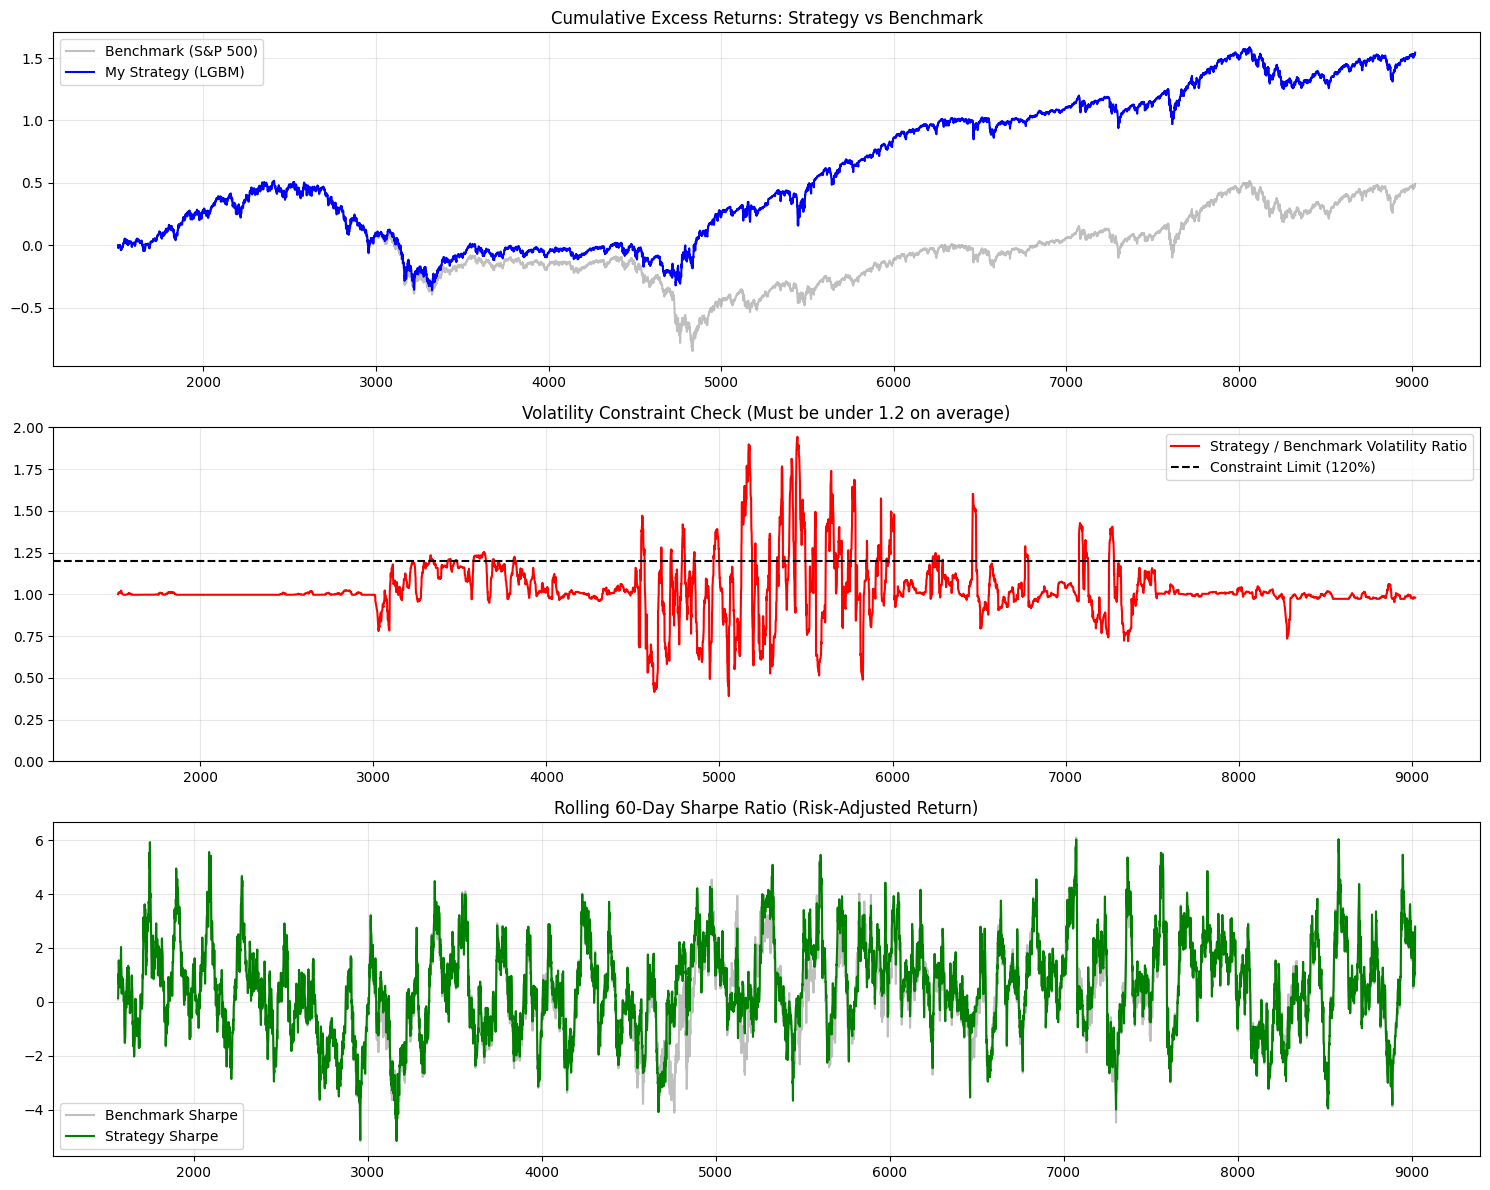

---------------------------------------------------------

🚀 Setting up inference server...

✅ Done!


In [2]:
import os
import gc
from pathlib import Path
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
import kaggle_evaluation.default_inference_server

# ---------------------------------------------------------
# 1. setting
# ---------------------------------------------------------
DATA_PATH = Path('/kaggle/input/hull-tactical-market-prediction/')
MIN_SIGNAL = 0.0
MAX_SIGNAL = 2.0
SIGNAL_MULTIPLIER = 400.0

# 변동성 제약 완화 (수익률 방어)
# 너무 자주 발동되지 않도록 임계값을 높이고(1.0 -> 1.5), 페널티를 줄임
VOL_THRESHOLD = 1.5
VOL_PENALTY = 0.8

LGBM_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 500,     
    'learning_rate': 0.05,   
    'num_leaves': 31,       
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,        
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# ---------------------------------------------------------
# 2. Feature Engineering 
# ---------------------------------------------------------
def create_features(df: pl.DataFrame) -> pl.DataFrame:
    vol_window = 20 # window size
    
    return (
        df.with_columns([
            # 1. Interest Rate Change
            (pl.col('I2') - pl.col('I1')).alias('U1'),
            
            # 2. Momentum Ratio 
            (pl.col('M11') / ((pl.col('I2') + pl.col('I9') + pl.col('I7')) / 3)).alias('U2'),
            
            # 3. Volatility 
            # 모델 학습에는 넣되, 너무 복잡한 파생 변수는 제외
            pl.col('P8').rolling_std(window_size=vol_window).fill_null(0).alias('VOL_20'),
            
            # 4. Simple Momentum
            (pl.col('P8') - pl.col('P8').shift(5)).fill_null(0).alias('MOM_5')
        ])
        .select([
            'date_id', 'target', 
            'S2', 'E2', 'E3', 'P8', 'P9', 'P10', 'P12', 'P13', 'S1', 'S5', 'I2', 
            'U1', 'U2', 'VOL_20', 'MOM_5'
        ])
        # 결측치 처리: EWM이 가장 부드럽게 채워줌 (단순 0보다 나음)
        .with_columns([
             pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5)) 
             for col in ['S2', 'E2', 'E3', 'P8', 'P9', 'P10', 'P12', 'P13', 'S1', 'S5', 'I2', 'U1', 'U2', 'VOL_20', 'MOM_5']
        ])
        .fill_null(0) # EWM으로도 안 채워진 앞부분 처리
    )

def convert_to_signal(prediction: float) -> float:
    return np.clip(prediction * SIGNAL_MULTIPLIER + 1, MIN_SIGNAL, MAX_SIGNAL)

# ---------------------------------------------------------
# 3. 학습 및 모델링
# ---------------------------------------------------------
print('📊 Loading training data...')
train = (
    pl.read_csv(DATA_PATH / 'train.csv')
    .rename({'market_forward_excess_returns': 'target'})
    .with_columns(pl.exclude('date_id').cast(pl.Float64, strict=False))
)

print('🛠 Applying Feature Engineering...')
train_df = create_features(train)
FEATURES = [col for col in train_df.columns if col not in ['date_id', 'target']]
print(f"Selected Features ({len(FEATURES)}): {FEATURES}")

X = train_df.select(FEATURES).to_numpy()
y = train_df.get_column('target').to_numpy()

# StandardScaler 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('\n🤖 Training LightGBM Model...')
model = LGBMRegressor(**LGBM_PARAMS)
model.fit(X_scaled, y)
print('✓ Model trained successfully.')

# Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance 추출
importances = model.feature_importances_
feature_names = FEATURES

# 데이터프레임으로 변환
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show() # 

# =========================================================
# 3-1. Time-Series Cross-Validation & Performance Analysis
# (검증과 동시에 시각화를 위한 데이터를 수집하는 단계)
# =========================================================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt
import pandas as pd # 그래프용 데이터 처리를 위해 필요

print('\n🔄 Starting Time-Series Cross-Validation & Simulation...')

# 1. 시뮬레이션을 위한 준비
# 전체 데이터의 날짜와 변동성 정보를 가져옵니다 (제약 조건 적용을 위해)
vol_20_all = train_df.get_column('VOL_20').to_numpy()
dates_all = train_df.get_column('date_id').to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

# OOF(Out-Of-Fold) Signals: 검증 데이터에 대한 모델의 예측값(신호)을 저장할 배열
# 초기값은 NaN으로 채움
oof_signals = np.full(len(y), np.nan)

for fold, (train_index, val_index) in enumerate(tscv.split(X_scaled)):
    # 데이터 분할
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # 모델 학습
    cv_model = LGBMRegressor(**LGBM_PARAMS)
    cv_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50, verbose=False),
            log_evaluation(period=0)
        ]
    )
    
    # 예측 (Raw Prediction)
    preds = cv_model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
    cv_scores.append(rmse)
    
    # -----------------------------------------------------
    # [시뮬레이션 로직] 예측값 -> 신호 변환 -> 변동성 제약 적용
    # 이 부분이 "실전 투자"를 흉내내는 과정입니다.
    # -----------------------------------------------------
    val_vols = vol_20_all[val_index] # 해당 검증 구간의 변동성 가져오기
    fold_signals = []
    
    for i, pred in enumerate(preds):
        # 1. 신호 변환 (0 ~ 2)
        sig = convert_to_signal(pred)
        
        # 2. 리스크 관리 (Volatility Constraint)
        # 시장 변동성이 임계값을 넘으면 비중 축소
        if val_vols[i] > VOL_THRESHOLD:
            sig *= VOL_PENALTY
            
        fold_signals.append(sig)
    
    # 시뮬레이션된 신호를 저장 (나중에 그래프 그릴 때 사용)
    oof_signals[val_index] = fold_signals
    
    print(f"  [Fold {fold+1}] Validation RMSE: {rmse:.6f}")

print(f"✅ Average Time-Series CV RMSE: {np.mean(cv_scores):.6f}")


# =========================================================
# [NEW] 성과 분석 및 시각화 (Visualization)
# 리포트에 들어갈 3가지 필수 그래프를 그립니다.
# =========================================================
print('\n📈 Generating Performance Plots...')

# 예측값이 존재하는 구간만 추출 (앞부분 학습 데이터 제외)
valid_mask = ~np.isnan(oof_signals)
analysis_df = pd.DataFrame({
    'date_id': dates_all[valid_mask],
    'benchmark_return': y[valid_mask],       # S&P 500 (Target)
    'my_signal': oof_signals[valid_mask],    # 내 모델의 투자 비중
    'vol_20': vol_20_all[valid_mask]         # 시장 변동성
})

# 전략 수익률 계산 (내 비중 * 시장 수익률)
# (단순화를 위해 Transaction Cost는 제외)
analysis_df['strategy_return'] = analysis_df['my_signal'] * analysis_df['benchmark_return']

# 1. 누적 수익률 (Cumulative Return)
analysis_df['cum_bench'] = analysis_df['benchmark_return'].cumsum()
analysis_df['cum_strat'] = analysis_df['strategy_return'].cumsum()

# 2. 변동성 비율 (Volatility Ratio) - 120% 제약 준수 여부 확인용
# 20일 롤링 변동성 비율 계산
analysis_df['roll_vol_bench'] = analysis_df['benchmark_return'].rolling(20).std()
analysis_df['roll_vol_strat'] = analysis_df['strategy_return'].rolling(20).std()
analysis_df['vol_ratio'] = analysis_df['roll_vol_strat'] / analysis_df['roll_vol_bench']

# 3. Rolling Sharpe Ratio (Local Sharpe-variant)
# 샤프 지수 = 평균 수익률 / 수익률 표준편차 * sqrt(252) (연율화)
window = 60
analysis_df['roll_sharpe_bench'] = (analysis_df['benchmark_return'].rolling(window).mean() / 
                                    analysis_df['benchmark_return'].rolling(window).std()) * np.sqrt(252)
analysis_df['roll_sharpe_strat'] = (analysis_df['strategy_return'].rolling(window).mean() / 
                                    analysis_df['strategy_return'].rolling(window).std()) * np.sqrt(252)
avg_local_sharpe = analysis_df['roll_sharpe_strat'].mean()

print(f"Local Sharpe-variant Score (Average): {avg_local_sharpe:.4f}")
# --- 그래프 그리기 ---
plt.figure(figsize=(15, 12))

# Subplot 1: 누적 수익률 비교
plt.subplot(3, 1, 1)
plt.plot(analysis_df['date_id'], analysis_df['cum_bench'], label='Benchmark (S&P 500)', color='gray', alpha=0.5)
plt.plot(analysis_df['date_id'], analysis_df['cum_strat'], label='My Strategy (LGBM)', color='blue', linewidth=1.5)
plt.title('Cumulative Excess Returns: Strategy vs Benchmark')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: 변동성 제약 준수 여부 (Volatility Ratio)
plt.subplot(3, 1, 2)
plt.plot(analysis_df['date_id'], analysis_df['vol_ratio'], color='red', label='Strategy / Benchmark Volatility Ratio')
plt.axhline(1.2, color='black', linestyle='--', label='Constraint Limit (120%)')
plt.title('Volatility Constraint Check (Must be under 1.2 on average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 2.0) # 잘 보이도록 Y축 제한

# Subplot 3: Rolling Sharpe Ratio
plt.subplot(3, 1, 3)
plt.plot(analysis_df['date_id'], analysis_df['roll_sharpe_bench'], label='Benchmark Sharpe', color='gray', alpha=0.5)
plt.plot(analysis_df['date_id'], analysis_df['roll_sharpe_strat'], label='Strategy Sharpe', color='green')
plt.title(f'Rolling {window}-Day Sharpe Ratio (Risk-Adjusted Return)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show() # 노트북에 그래프 출력
print("---------------------------------------------------------")

# ---------------------------------------------------------
# 4. Inference Server
# ---------------------------------------------------------
# 버퍼 준비
history_df = train.tail(50)
required_schema = history_df.schema
required_columns = history_df.columns

def predict(test: pl.DataFrame) -> float:
    global history_df
    
    # 1. Defensive Column Handling (에러 방지)
    if 'lagged_forward_returns' in test.columns:
        current_row = test.rename({'lagged_forward_returns': 'target'})
    else:
        current_row = test

    if 'target' not in current_row.columns:
        current_row = current_row.with_columns(pl.lit(0.0).alias('target'))

    missing_cols = set(required_columns) - set(current_row.columns)
    if missing_cols:
        current_row = current_row.with_columns([pl.lit(0.0).alias(col) for col in missing_cols])
    
    # 타입 및 순서 강제 일치
    current_row = current_row.select(required_columns).cast(required_schema)
    
    # 2. Update History
    history_df = pl.concat([history_df, current_row])
    if len(history_df) > 60:
        history_df = history_df.tail(60)
        
    # 3. Feature Engineering
    df_feat = create_features(history_df)
    current_feat = df_feat.tail(1).select(FEATURES).to_numpy()
    current_feat_scaled = scaler.transform(current_feat)
    
    # 4. Predict
    raw_pred = model.predict(current_feat_scaled)[0]
    signal = convert_to_signal(raw_pred)
    
    # 5. Optimized Volatility Constraint
    current_vol = df_feat.tail(1)['VOL_20'][0]
    
    # 전략: 변동성이 '매우' 높을 때만 비중을 '살짝' 줄인다.
    if current_vol > VOL_THRESHOLD: # 임계값 1.5 
        signal = signal * VOL_PENALTY # 페널티 0.8 
        
    return float(signal)

print('\n🚀 Setting up inference server...')
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway((str(DATA_PATH),))

print('\n✅ Done!')